In [1]:
import os
import glob
import torch
import numpy as np 
import nibabel as nib
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.transforms import LoadImage
from monai.handlers.utils import from_engine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        
        # Change labels from 255 to 1
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        
        # Randomly crop a patch from both image and label files
        RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[96, 96, 96],
                random_size=False,
        ),
     
        # Data augmentation transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ])


test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-2000, a_max=3000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="PLS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear")),
    ])

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [8]:
test_images = ['data/copd{patient_num}/copd{patient_num}_iBHCT.nii.gz'.format(patient_num=i) for i in range(1, 5)]


test_files = [{"image": img} for img in test_images]

In [5]:
print(test_files)

[{'image': 'data/copd1/copd1_iBHCT.nii.gz'}, {'image': 'data/copd2/copd2_iBHCT.nii.gz'}, {'image': 'data/copd3/copd3_iBHCT.nii.gz'}, {'image': 'data/copd4/copd4_iBHCT.nii.gz'}]


No. of images: 29
img intensity min.: -2000.0  max.: 2882.0


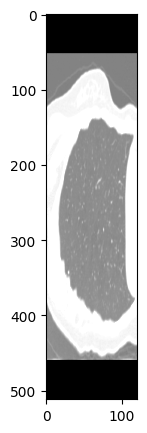

In [6]:
images = test_files[0]['image']


print('No. of images:', len(images))

img = nib.load(images).get_fdata()

print('img intensity min.:', np.min(img), ' max.:', np.max(img))

slice_idx = 100
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.show()

In [9]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [10]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [11]:
loader = LoadImage()

model.load_state_dict(torch.load("best_metric_model.pth", map_location=device))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

2024-12-22 16:24:00,782 INFO image_writer.py:197 - writing: out\copd1_iBHCT\copd1_iBHCT_seg.nii.gz
2024-12-22 16:24:32,776 INFO image_writer.py:197 - writing: out\copd2_iBHCT\copd2_iBHCT_seg.nii.gz
2024-12-22 16:25:15,170 INFO image_writer.py:197 - writing: out\copd3_iBHCT\copd3_iBHCT_seg.nii.gz
2024-12-22 16:25:49,514 INFO image_writer.py:197 - writing: out\copd4_iBHCT\copd4_iBHCT_seg.nii.gz
